In [44]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

!pip install torchsummary
import torchsummary

from skimage.data import astronaut

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
B = np.array([1,2,3])
A = torch.from_numpy(B)


### Tensor basics

tensor([1., 2., 3.])

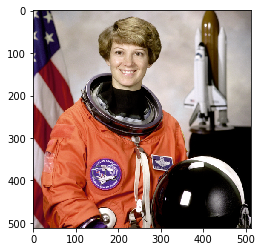

In [24]:
T = torch.from_numpy(np.array([1,2,3,4])).float()
T.exp_() # inplace operations end with _

# T.cuda() # moves data to GPU memory
numpy_Tensor = T.cpu().numpy() # create a numpy array out of torch.Tensor 

T.to('cpu')
# T.to('cuda')

im = astronaut()
plt.imshow(im)
torch.from_numpy(im)


### Autograd

In [54]:

x

tensor(10., requires_grad=True)

In [48]:
# Create tensors.
x = torch.tensor(10., requires_grad=True)

# Create the computetional graph
res = x ** 2

# propagate the gradients
# res.backward()

# Print out the gradients.
print("The derivative of x ** 2 is 2x")
# print("result:", float(x.grad))

print(x.grad)


The derivative of x ** 2 is 2x
None


# Loss Functions

In [6]:
preds = torch.Tensor([[0.2, 0.8],[0.9, 0.1]]).float()
target = torch.Tensor([0, 1]).long()

print("Cross Entropy:")
print(F.cross_entropy(preds, target))
# print(nn.CrossEntropyLoss()(preds, target))

preds = torch.Tensor([[1],[2],[0.9]])
target = torch.Tensor([[1.3], [2.4], [0.9]])

print(F.mse_loss(preds, target))
print(nn.MSELoss()(preds, target))

Cross Entropy:
tensor(1.1043)
tensor(0.0833)
tensor(0.0833)


### Disable gradient computation with no_grad context manager (useful during inference)

In [7]:
with torch.no_grad():
    t = torch.tensor([1,2,3]).float()
    t = t ** 2
    print(t)
    print(t.grad)
    

tensor([1., 4., 9.])
None


### get the available computational device CUDA if availble otherwise CPU


In [25]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


### Use the view function to get a new tensor with a different shape  but without touching the memory


In [9]:
t1 = torch.randn(1,5)
t1.view(5,1)

t.squeeze(0) # remove first dimension
t.unsqueeze(0) # expand by adding the first dimension


tensor([[1., 4., 9.]])

### Defining models
![alt text](https://i.stack.imgur.com/2MVdW.png "Title")


In [10]:
class Perceptron(nn.Module):
    def __init__(self, n_in, n_out):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(n_in, n_out, bias=True)

    def forward(self, x):
        return self.fc(x)

perceptron = torch.nn.Sequential(nn.Linear(1000, 1000))
p = Perceptron(1000, 1000)
torchsummary.summary(p.to(DEVICE), input_size=(1,1000,1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1        [-1, 1, 1000, 1000]       1,001,000
Total params: 1,001,000
Trainable params: 1,001,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.81
Forward/backward pass size (MB): 7.63
Params size (MB): 3.82
Estimated Total Size (MB): 15.26
----------------------------------------------------------------


In [11]:
for method in dir(p):
    if not method.startswith('_'): print(method)

add_module
apply
buffers
children
cpu
cuda
double
dump_patches
eval
extra_repr
fc
float
forward
half
load_state_dict
modules
named_buffers
named_children
named_modules
named_parameters
parameters
register_backward_hook
register_buffer
register_forward_hook
register_forward_pre_hook
register_parameter
share_memory
state_dict
to
train
training
type
zero_grad


### Custom model weights

In [12]:
def custom_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
p.apply(custom_weights)

Perceptron(
  (fc): Linear(in_features=1000, out_features=1000, bias=True)
)

### Model persistance and loading

In [13]:
p = Perceptron(2, 2)
torch.save(p.state_dict(), 'model.torch')
p.load_state_dict(torch.load('model.torch'))


print(p.state_dict())


OrderedDict([('fc.weight', tensor([[ 0.1703,  0.0075],
        [ 0.1398, -0.6051]])), ('fc.bias', tensor([-0.3570, -0.3908]))])


### Parameters

In [14]:
for params in p.parameters():
    print(params)

Parameter containing:
tensor([[ 0.1703,  0.0075],
        [ 0.1398, -0.6051]], requires_grad=True)
Parameter containing:
tensor([-0.3570, -0.3908], requires_grad=True)


### Activation functions

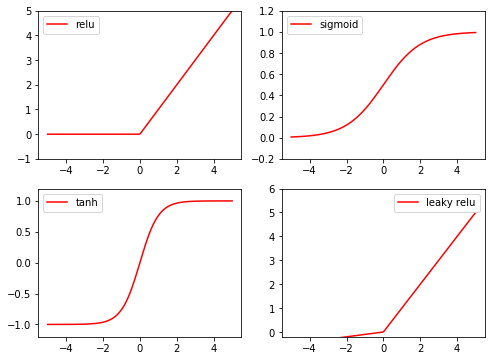

In [16]:

# fake data
x = torch.linspace(-5, 5, 200)  # x data (tensor), shape=(100, 1)
x_np = x.data.numpy()   # numpy array for plotting

# following are popular activation functions
y_relu = torch.relu(x).data.numpy()
y_sigmoid = torch.sigmoid(x).data.numpy()
y_tanh = torch.tanh(x).data.numpy()
y_softplus = F.leaky_relu(x, negative_slope=0.1).data.numpy() # there's no softplus in torch
# y_softmax = torch.softmax(x, dim=0).data.numpy() softmax is a special kind of activation function, it is about probability

# plt to visualize these activation function
plt.figure(1, figsize=(8, 6))
plt.subplot(221)
plt.plot(x_np, y_relu, c='red', label='relu')
plt.ylim((-1, 5))
plt.legend(loc='best')

plt.subplot(222)
plt.plot(x_np, y_sigmoid, c='red', label='sigmoid')
plt.ylim((-0.2, 1.2))
plt.legend(loc='best')

plt.subplot(223)
plt.plot(x_np, y_tanh, c='red', label='tanh')
plt.ylim((-1.2, 1.2))
plt.legend(loc='best')

plt.subplot(224)
plt.plot(x_np, y_softplus, c='red', label='leaky relu')
plt.ylim((-0.2, 6))
plt.legend(loc='best')

plt.show()

### Modularity

In [17]:
def conv_bn_pool(inch, outch, kernel_size=3):
    return  nn.Sequential(
                nn.Conv2d(inch, outch, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(outch),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))


class My_Model(nn.Module):
        

    def __init__(self, num_of_class):
        super(My_Model, self).__init__()
        
        self.layer1 = conv_bn_pool(1, 16)
        self.layer2 = conv_bn_pool(16, 32)
        self.fc = nn.Linear(7 * 7 * 32, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
    


In [18]:
net = My_odel(100)
torchsummary.summary(net.to(DEVICE), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Linear-9                  [-1, 100]         156,900
Total params: 161,796
Trainable params: 161,796
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 0.62
Estimated Total Size (MB): 1.09
-------------------------------------------

### 1 Generate a random  torch Tensor  with a depth of 32 and with/height 64  pass it trough a 2d max_pool operation

In [26]:
# Your cde here

### 2 Its a common operation to find the index where a tensor has the  a max value. 
For instance given a tensor   [0.1, 0.5, 0.9] you would like to get the number 2. as 0.9 is the max value (remember python uses 0-indexing most of the time)

In [37]:
# This could be a output tensor from a 10-class classification problem and a batch size od 32. 
# How do you find the index of the max value in each of the batches?
tensor = torch.randn((32, 10))
tensor.argmax(dim=1)


tensor([1, 6, 3, 9, 8, 1, 8, 0, 6, 5, 7, 2, 0, 3, 2, 0, 7, 2, 4, 6, 9, 9, 4, 7,
        9, 0, 8, 2, 2, 4, 4, 4])

### 3 Reshaping


In [39]:
# Change X shape into (10, 3)
X = torch.ones(5, 6)
Y = X.view(10, 3)

# Remove all the dimensions of size 1 in X.

X = torch.randn(10, 10, 1, 1)
Y = X.squeeze()


### 4 Stacking

In [40]:
# stack x, y, and z vertically.

x = torch.Tensor([1, 4])
y = torch.Tensor([2, 5])
z = torch.Tensor([3, 6])

O = torch.stack([x, y, z])
# print(O)

In [43]:
### Counting 
# Get the indices of all nonzero elements in X.
X = torch.Tensor([[0,1,7,0,0],[3,0,0,2,19]])
X.nonzero()

tensor([[0, 1],
        [0, 2],
        [1, 0],
        [1, 3],
        [1, 4]])

### nn.Conv

In [46]:
# Why is the output of this cell a tensor with a shape 1,64,6,6 - what can we do to get the same input and output shape

v =torch.rand(1, 32, 8, 8)
print(nn.Conv2d(32, 64, 3)(v).shape)


torch.Size([1, 64, 6, 6])
